# Rare Disease Subtyping (ALS)

## Initialize Varibales and Libraries

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, silhouette_score

INPUT_CSV = "synthetic_patients.csv"
OUT_DIR = "clients_data"  # will create one csv per superpopulation
SUPERPOP_COL = "superpopulation"

drop_cols = {
    "patient_id",
    "superpopulation",
    "n_variants_carried",
    "primary_gene",
    "primary_condition",
    "primary_subtype",
    "onset_type",
    "base_impact",
    "allelic_ratio",
    "ancestral_modifier",
    "modifier_type",
    "consequence_modifier",
    "interaction_score",
    "predicted_progression",
    "all_genes",
    "all_subtypes",
}

## Data prep (split by ancestry clients, assuming data was collected by a separate client)

In [2]:
df = pd.read_csv(INPUT_CSV)

os.makedirs(OUT_DIR, exist_ok=True)
for sp, g in df.groupby(SUPERPOP_COL):
    out = os.path.join(OUT_DIR, f"client_{sp}.csv")
    g.to_csv(out, index=False)
    print("wrote", out, ", rows:", len(g))

wrote clients_data/client_AFR.csv , rows: 3000
wrote clients_data/client_AMR.csv , rows: 3000
wrote clients_data/client_EAS.csv , rows: 3000
wrote clients_data/client_EUR.csv , rows: 3000
wrote clients_data/client_SAS.csv , rows: 3000


## Calculate Silhouette Score and WCSS

Running k=1...
2026-01-10 14:48:58,222 - INFO - Initializing ScatterAndGather workflow for Federated Averaging.
2026-01-10 14:48:58,224 - INFO - Beginning ScatterAndGather training phase.
2026-01-10 14:48:58,225 - INFO - Round 0 started.
2026-01-10 14:49:02,455 - INFO - Contribution from AMR ACCEPTED by the aggregator at round 0.
2026-01-10 14:49:02,527 - INFO - Contribution from EUR ACCEPTED by the aggregator at round 0.
2026-01-10 14:49:02,592 - INFO - Contribution from AFR ACCEPTED by the aggregator at round 0.
2026-01-10 14:49:02,645 - INFO - Contribution from EAS ACCEPTED by the aggregator at round 0.
2026-01-10 14:49:03,342 - INFO - Contribution from SAS ACCEPTED by the aggregator at round 0.
2026-01-10 14:49:03,595 - INFO - Start aggregation.
round 00 inertia 431631.12 moved 20.9325 counts [15000]
2026-01-10 14:49:03,599 - INFO - End aggregation.
2026-01-10 14:49:03,600 - INFO - Round 0 finished.
2026-01-10 14:49:03,648 - INFO - Round 1 started.
2026-01-10 14:49:04,662 - INFO - 

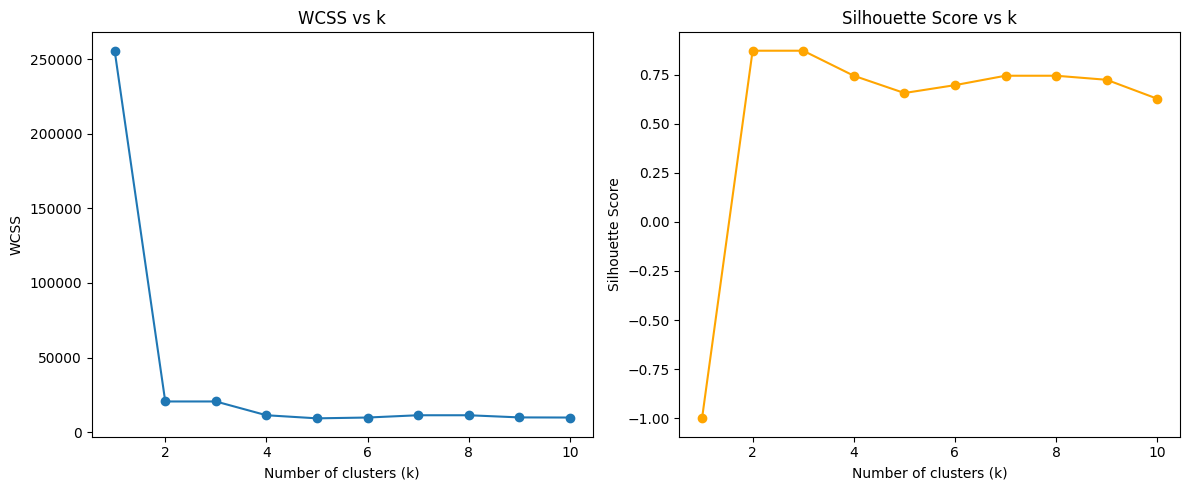

In [3]:
ws = []
sils = []
for i in range(1, 11):
    print(f"Running k={i}...")
    !python "main.py" --k {i} --workspace output_nvflare_kmeans_{i}

    metrics_paths = glob.glob(f"output_nvflare_kmeans_{i}/**/kmeans_metrics.csv", recursive=True)
    centers_paths = glob.glob(f"output_nvflare_kmeans_{i}/**/final_centers.npy", recursive=True)

    metrics_path = sorted(metrics_paths)[-1]
    centers_path = sorted(centers_paths)[-1]

    m = pd.read_csv(metrics_path)
    centers = np.load(centers_path)

    # load pooled data
    df = pd.read_csv(INPUT_CSV)
    feat_cols = [c for c in df.columns if c not in drop_cols]
    X = df[feat_cols].to_numpy(dtype=np.float32)

    Xs = X
    Cs = centers
    
    d2 = ((Xs[:, None, :] - Cs[None, :, :]) ** 2).sum(axis=2)
    labels = d2.argmin(axis=1)

    # compute WCSS (Within-Cluster Sum of Squares)
    wcss = 0.0
    for k in range(Cs.shape[0]):
        cluster_points = Xs[labels == k]
        wcss += ((cluster_points - Cs[k]) ** 2).sum()
    ws.append((i, wcss))
    
    # compute silhouette score
    n = Xs.shape[0]
    try:
        sil = silhouette_score(Xs, labels, metric="euclidean")
    except:
        sil = -1.0
    sils.append((i, sil))
    
print("k and sil vs WCSS:")
ws = np.array(ws)
sils = np.array(sils)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(ws[:, 0], ws[:, 1], marker='o')
plt.title("WCSS vs k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS")
plt.subplot(1, 2, 2)
plt.plot(sils[:, 0], sils[:, 1], marker='o', color='orange')
plt.title("Silhouette Score vs k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()


## Calculate Optimal k

In [4]:
min_val = min(ws[:, 1])
k = [i for i, x in enumerate(ws[:, 1]) if x == min_val][0] + 1
print("Optimal k (min WCSS):", k)

Optimal k (min WCSS): 5


In [5]:
print("Silhouette score of optimal k:", round(sils[k-1, 1], 2))

Silhouette score of optimal k: 0.66


## Bootstrap stability for clustering
- answers: do we get the same clustering if we resample patients and rerun k means from the same initialization?

In [6]:
def bootstrap_stability(X, base_labels, k, init_centers, B=50, seed=0):
    rng = np.random.default_rng(seed)
    n = X.shape[0]
    scores = []
    for b in range(B):
        idx = rng.integers(0, n, size=n)  # bootstrap sample indices
        Xb = X[idx]

        km = KMeans(
            n_clusters=k,
            init=init_centers,
            n_init=1,
            max_iter=100,
            random_state=seed + b,
        ).fit(Xb)

        # predict labels on full X using bootstrapped centers
        Cb = km.cluster_centers_.astype(np.float32)
        d2 = ((X[:, None, :] - Cb[None, :, :]) ** 2).sum(axis=2)
        pred = d2.argmin(axis=1)

        scores.append(adjusted_rand_score(base_labels, pred))
    return np.array(scores)

metrics_paths = glob.glob(f"output_nvflare_kmeans_{k}/**/kmeans_metrics.csv", recursive=True)
centers_paths = glob.glob(f"output_nvflare_kmeans_{k}/**/final_centers.npy", recursive=True)

metrics_path = sorted(metrics_paths)[-1]
centers_path = sorted(centers_paths)[-1]

m = pd.read_csv(metrics_path)
centers = np.load(centers_path)

# load pooled data
df = pd.read_csv(INPUT_CSV)
feat_cols = [c for c in df.columns if c not in drop_cols]
X = df[feat_cols].to_numpy(dtype=np.float32)

Xs = X
Cs = centers

d2 = ((Xs[:, None, :] - Cs[None, :, :]) ** 2).sum(axis=2)
labels = d2.argmin(axis=1)

st = bootstrap_stability(Xs, labels, k=centers.shape[0], init_centers=centers, B=50, seed=7)
print("ARI mean", st.mean(), "std", st.std(), "min", st.min(), "max", st.max())

ARI mean 1.0 std 0.0 min 1.0 max 1.0


# Visualization

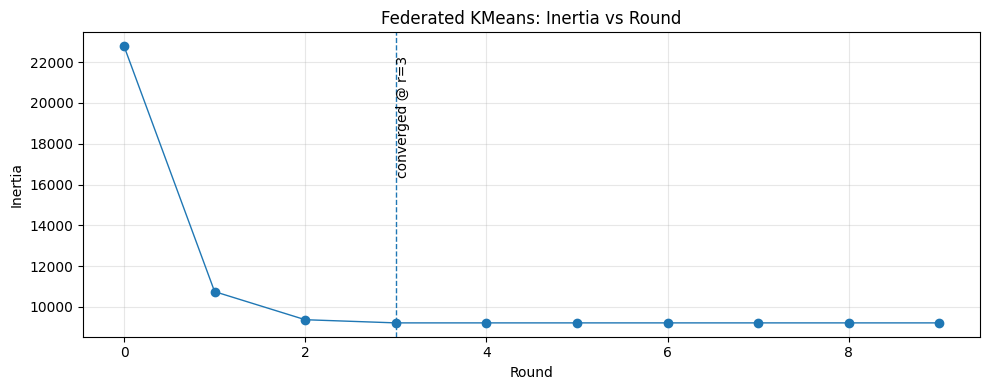

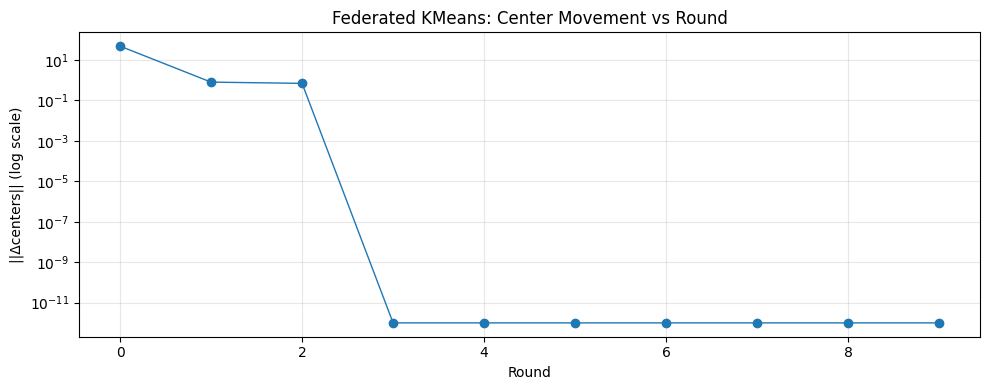

Converged round: 3
Final inertia: 9219.8017578125
Final counts: {'count_0': 287, 'count_1': 3287, 'count_2': 1999, 'count_3': 8582, 'count_4': 845}
Dead clusters: []


In [7]:
csv_path = glob.glob(f"output_nvflare_kmeans_{k}/**/kmeans_metrics.csv", recursive=True)
m = pd.read_csv(csv_path[-1]).sort_values("round").reset_index(drop=True)

rounds = m["round"].to_numpy()
inertia = m["inertia"].to_numpy()
moved = m["moved"].to_numpy()

count_cols = [c for c in m.columns if c.startswith("count_")]
counts = m[count_cols].to_numpy()
total = counts.sum(axis=1)
props = counts / total[:, None]

# find convergence round: first round where moved == 0 and stays 0
conv_r = None
for i in range(len(rounds)):
    if moved[i] == 0 and np.all(moved[i:] == 0):
        conv_r = int(rounds[i])
        break

# Inertia with improvement annotations
plt.figure(figsize=(10,4))
plt.plot(rounds, inertia, marker="o", linewidth=1)
plt.grid(True, alpha=0.3)
plt.xlabel("Round")
plt.ylabel("Inertia")
plt.title("Federated KMeans: Inertia vs Round")
if conv_r is not None:
    plt.axvline(conv_r, linestyle="--", linewidth=1)
    plt.text(conv_r, inertia.max()*0.98, f"converged @ r={conv_r}", rotation=90, va="top")
plt.tight_layout()
plt.show()

# Movement (log scale helps when it quickly goes to 0)
eps = 1e-12
plt.figure(figsize=(10,4))
plt.plot(rounds, moved + eps, marker="o", linewidth=1)
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.xlabel("Round")
plt.ylabel("||Δcenters|| (log scale)")
plt.title("Federated KMeans: Center Movement vs Round")
plt.tight_layout()
plt.show()

# summary
final_counts = dict(zip(count_cols, counts[-1].tolist()))
dead = [c for c, v in final_counts.items() if v == 0]

print("Converged round:", conv_r)
print("Final inertia:", float(inertia[-1]))
print("Final counts:", final_counts)
print("Dead clusters:", dead)

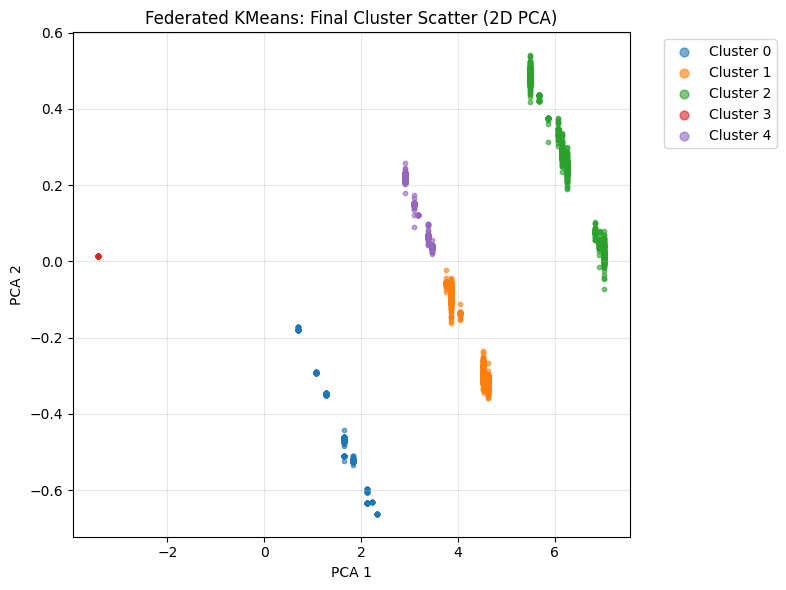

In [8]:
# Reduce to 2D for plotting
pca = PCA(n_components=2, random_state=0)
X_2d = pca.fit_transform(Xs)

# Scatter plot
plt.figure(figsize=(8,6))
num_clusters = centers.shape[0]
for i in range(num_clusters):
    cluster_points = X_2d[labels == i]
    if cluster_points.shape[0] > 0:
        plt.scatter(cluster_points[:,0], cluster_points[:,1], label=f"Cluster {i}", s=10, alpha=0.6)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Federated KMeans: Final Cluster Scatter (2D PCA)")
plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
# CONFIG
OUTPUT_DIR = "output_nvflare_kmeans"

df = pd.read_csv(INPUT_CSV)

genes = df["primary_gene"]

drop_cols = {
    "patient_id", "superpopulation", "n_variants_carried",
    "primary_gene", "primary_condition", "primary_subtype",
    "onset_type", "base_impact", "allelic_ratio",
    "ancestral_modifier", "modifier_type",
    "consequence_modifier", "interaction_score",
    "predicted_progression", "all_genes", "all_subtypes"
}

feat_cols = [c for c in df.columns if c not in drop_cols]
X = df[feat_cols].to_numpy(dtype=np.float32)

Xs = X
Cs = centers

# Assign clusters
d2 = ((Xs[:, None, :] - Cs[None, :, :]) ** 2).sum(axis=2)
labels = d2.argmin(axis=1)

# Primary_gene → cluster mapping
cluster_df = pd.DataFrame({
    "primary_gene": genes,
    "cluster": labels
})

# counts per (cluster, gene)
gene_cluster_counts = (
    cluster_df
    .value_counts(["cluster", "primary_gene"])
    .rename("count")
    .reset_index()
    .sort_values(["cluster", "count"], ascending=[True, False])
)

# Save outputs
gene_cluster_counts.to_csv("primary_gene_by_cluster_counts.csv", index=False)

print("Saved: primary_gene_by_cluster_counts.csv")

Saved: primary_gene_by_cluster_counts.csv
